Occupancy Detection based on ECO dataset: Summer
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [2]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [3]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [4]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

The following function calculates the sad: 

In [5]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

The following function detects the on-off status:

In [6]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

In [7]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test,model):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()


In [12]:
from os import walk
path = "C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/03_sm_csv/03"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [13]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

138

In [14]:
df2 = pd.read_csv("C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/03_occupancy_csv/03_summer.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

57

In [15]:
import datetime
summer = df2.index.tolist()
df_summer = {}
for key in df.keys():
    if key in summer:
        df_summer[key]=df[key]
len(df_summer)
#df_summer["20120730"]

57

In [16]:
n = 900  #chunk row size
summer_features = pd.DataFrame()
for day, data in df_summer.items():
    list_df_summer = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_summer:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
    
    summer_features = summer_features.append(data)
summer_features.loc[summer_features.ptime < 25, 'ptime'] = 0
summer_features.loc[summer_features.ptime > 89, 'ptime'] = 0
summer_features = summer_features.loc[(summer_features['ptime'] >0)]
summer_features['ptime'] = summer_features['ptime'] - 24

summer_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,14.518,7.703,4.549,27.391,15.304,682.854,5.540,703.092,14.894246,29.104397,...,0.788800,0.0,0.0,0.0,0.0,0.786,675.151,0.991,675.701,1.0
25,14.426,7.769,4.639,27.667,15.448,77.697,5.597,97.848,14.908138,66.911681,...,0.996126,0.0,0.0,0.0,0.0,1.022,69.928,0.958,70.181,2.0
26,14.453,0.000,0.000,14.453,15.448,8.471,5.578,28.925,14.898127,5.853557,...,0.995751,0.0,0.0,0.0,0.0,0.995,8.471,5.578,14.472,3.0
27,14.481,0.000,0.000,14.481,15.313,0.000,0.000,15.313,14.906007,0.000000,...,-0.078009,0.0,0.0,0.0,0.0,0.832,0.000,0.000,0.832,4.0
28,14.430,0.000,0.000,14.509,15.368,923.459,0.000,938.456,14.870832,45.242106,...,0.714424,0.0,0.0,0.0,0.0,0.938,923.459,0.000,923.947,5.0
29,14.462,0.000,0.000,14.486,15.271,76.097,0.000,91.004,14.847050,45.907011,...,0.998504,0.0,0.0,0.0,0.0,0.809,76.097,0.000,76.518,6.0
30,14.416,0.000,0.000,14.416,15.424,0.000,0.000,15.424,14.853643,0.000000,...,-0.078562,0.0,0.0,0.0,0.0,1.008,0.000,0.000,1.008,7.0
31,14.458,0.000,0.000,14.458,15.531,0.000,0.000,15.531,14.829626,0.000000,...,-0.147580,0.0,0.0,0.0,0.0,1.073,0.000,0.000,1.073,8.0
32,14.551,0.000,0.000,14.588,15.354,1013.070,0.000,1028.000,14.896906,57.093638,...,0.654037,0.0,0.0,0.0,0.0,0.803,1013.070,0.000,1013.412,9.0
33,14.370,0.000,0.000,14.481,15.318,2100.110,0.000,2114.930,14.874467,324.880503,...,0.993892,0.0,0.0,0.0,0.0,0.948,2100.110,0.000,2100.449,10.0


In [19]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_summer = []
    list_oc_summer = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_summer:
        occ_summer.append(np.bincount(chunk).argmax())
    occ_summer = occ_summer[24:89]
#     print(len(occ_summer))
    cuml_list.extend(occ_summer)
#     print(len(cuml_list))
occ_summer_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
print(occ_summer_data.shape)  
    

(3705, 1)


Replacing all the 'nan' values by '0'

In [20]:
summer_features[np.isnan(summer_features)] = 0

Model with Manual Validation:
-----------

In [21]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

Data Pre-processing:


In [22]:
X = np.array(summer_features)
print('X dim: ',X.shape)
y = np.array(occ_summer_data)
print('y dim: ',y.shape)

X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_tesy dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_tesy dim: ', y_test.shape)

X dim:  (3705, 33)
y dim:  (3705, 1)
X_train dim:  (3149, 33, 1)
X_tesy dim:  (556, 33, 1)
y_train dim:  (3149, 1)
y_tesy dim:  (556, 1)


In [23]:
features = X_train.shape[1]
model = init_model(features)
model.summary()

W0829 13:41:27.292853  6648 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 13:41:27.317454  6648 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 13:41:27.321454  6648 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 13:41:27.498464  6648 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0829 13:41:27.557467  6648 deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 256)           1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 33, 64)            32832     
__________

Training and Testing:


Train on 3149 samples, validate on 556 samples
Epoch 1/150
 - 10s - loss: 0.5799 - acc: 0.7250 - val_loss: 0.5204 - val_acc: 0.8058
Epoch 2/150
 - 6s - loss: 0.4697 - acc: 0.7895 - val_loss: 0.4660 - val_acc: 0.7968
Epoch 3/150
 - 6s - loss: 0.4388 - acc: 0.8133 - val_loss: 0.4032 - val_acc: 0.8345
Epoch 4/150
 - 6s - loss: 0.4163 - acc: 0.8212 - val_loss: 0.3715 - val_acc: 0.8489
Epoch 5/150
 - 6s - loss: 0.4078 - acc: 0.8218 - val_loss: 0.3691 - val_acc: 0.8489
Epoch 6/150
 - 6s - loss: 0.4008 - acc: 0.8361 - val_loss: 0.3611 - val_acc: 0.8507
Epoch 7/150
 - 6s - loss: 0.3868 - acc: 0.8336 - val_loss: 0.3567 - val_acc: 0.8435
Epoch 8/150
 - 6s - loss: 0.3924 - acc: 0.8323 - val_loss: 0.3528 - val_acc: 0.8507
Epoch 9/150
 - 6s - loss: 0.3835 - acc: 0.8387 - val_loss: 0.3590 - val_acc: 0.8489
Epoch 10/150
 - 6s - loss: 0.3801 - acc: 0.8339 - val_loss: 0.3602 - val_acc: 0.8525
Epoch 11/150
 - 6s - loss: 0.3894 - acc: 0.8311 - val_loss: 0.3806 - val_acc: 0.8291
Epoch 12/150
 - 6s - loss:

Epoch 97/150
 - 5s - loss: 0.2773 - acc: 0.8771 - val_loss: 0.3375 - val_acc: 0.8435
Epoch 98/150
 - 6s - loss: 0.2829 - acc: 0.8777 - val_loss: 0.3441 - val_acc: 0.8453
Epoch 99/150
 - 6s - loss: 0.2819 - acc: 0.8762 - val_loss: 0.3476 - val_acc: 0.8435
Epoch 100/150
 - 6s - loss: 0.2902 - acc: 0.8676 - val_loss: 0.3459 - val_acc: 0.8399
Epoch 101/150
 - 6s - loss: 0.2847 - acc: 0.8736 - val_loss: 0.3433 - val_acc: 0.8453
Epoch 102/150
 - 6s - loss: 0.2777 - acc: 0.8768 - val_loss: 0.3442 - val_acc: 0.8417
Epoch 103/150
 - 6s - loss: 0.2805 - acc: 0.8784 - val_loss: 0.3385 - val_acc: 0.8471
Epoch 104/150
 - 6s - loss: 0.2785 - acc: 0.8755 - val_loss: 0.3433 - val_acc: 0.8327
Epoch 105/150
 - 6s - loss: 0.2849 - acc: 0.8768 - val_loss: 0.3433 - val_acc: 0.8381
Epoch 106/150
 - 6s - loss: 0.2819 - acc: 0.8723 - val_loss: 0.3495 - val_acc: 0.8345
Epoch 107/150
 - 6s - loss: 0.2872 - acc: 0.8828 - val_loss: 0.3374 - val_acc: 0.8435
Epoch 108/150
 - 6s - loss: 0.2805 - acc: 0.8784 - val_lo

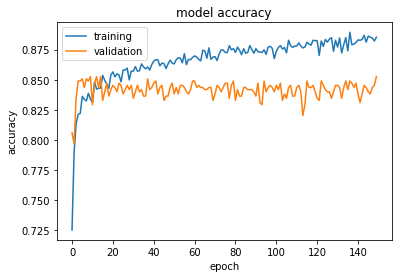

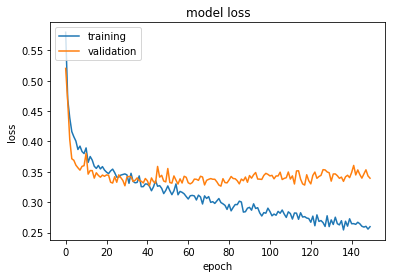

In [24]:
history = LossHistory()
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

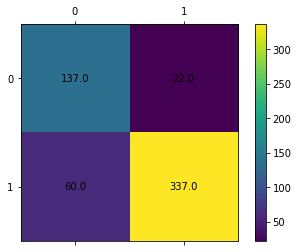

In [25]:
conf_matrix(X_test,y_test,model)

Classification error: 85.25

Early Stopping:
------

In [26]:
model = init_model(features)

Training and Testing:


Train on 3149 samples, validate on 556 samples
Epoch 1/150
 - 10s - loss: 0.5914 - acc: 0.7228 - val_loss: 0.5707 - val_acc: 0.7788
Epoch 2/150
 - 6s - loss: 0.4768 - acc: 0.7964 - val_loss: 0.4918 - val_acc: 0.7914
Epoch 3/150
 - 6s - loss: 0.4264 - acc: 0.8177 - val_loss: 0.3872 - val_acc: 0.8363
Epoch 4/150
 - 6s - loss: 0.4179 - acc: 0.8209 - val_loss: 0.3961 - val_acc: 0.8417
Epoch 5/150
 - 6s - loss: 0.3967 - acc: 0.8190 - val_loss: 0.3612 - val_acc: 0.8381
Epoch 6/150
 - 6s - loss: 0.3941 - acc: 0.8257 - val_loss: 0.3511 - val_acc: 0.8417
Epoch 7/150
 - 6s - loss: 0.3927 - acc: 0.8330 - val_loss: 0.3640 - val_acc: 0.8399
Epoch 8/150
 - 6s - loss: 0.3855 - acc: 0.8333 - val_loss: 0.3679 - val_acc: 0.8219
Epoch 9/150
 - 6s - loss: 0.3868 - acc: 0.8403 - val_loss: 0.3532 - val_acc: 0.8525
Epoch 10/150
 - 6s - loss: 0.3785 - acc: 0.8450 - val_loss: 0.3470 - val_acc: 0.8471
Epoch 11/150
 - 6s - loss: 0.3782 - acc: 0.8422 - val_loss: 0.3468 - val_acc: 0.8507
Epoch 12/150
 - 6s - loss:

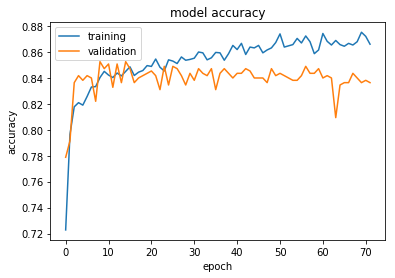

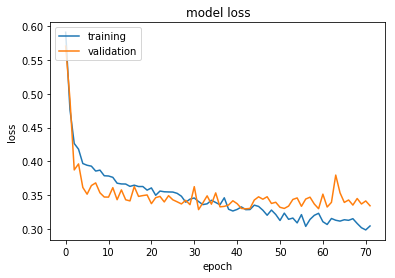

In [27]:
history = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history,es],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

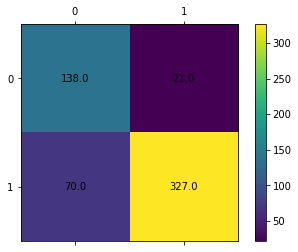

In [28]:
conf_matrix(X_test,y_test,model)

Model with K-fold Validation:
----------

acc: 85.85%


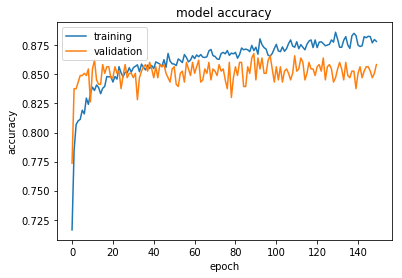

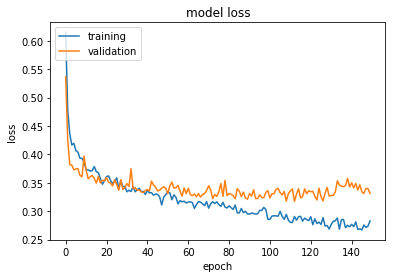

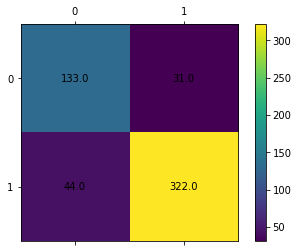

acc: 83.40%


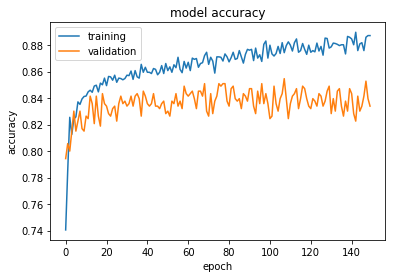

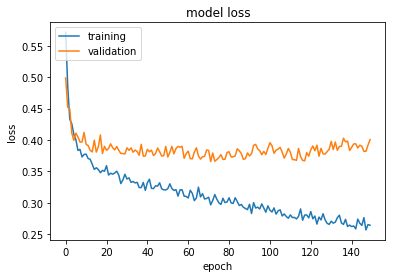

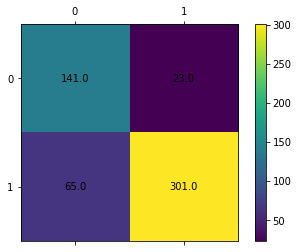

acc: 86.98%


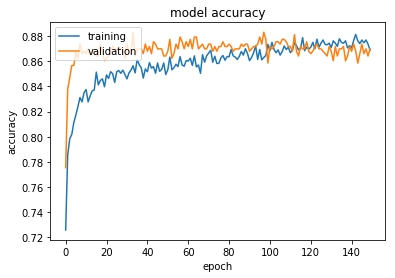

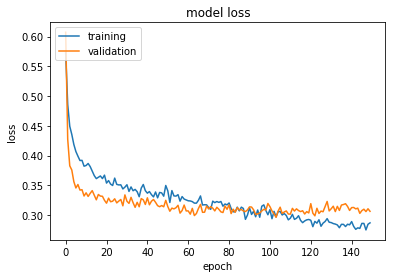

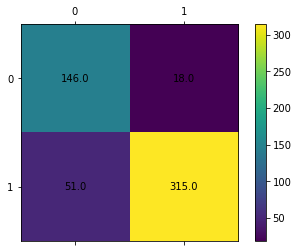

acc: 86.20%


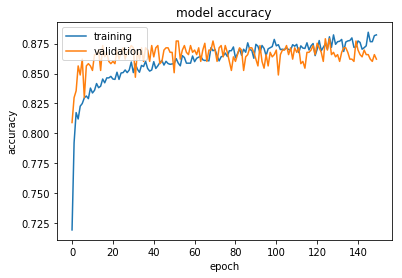

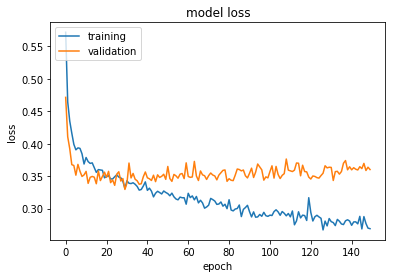

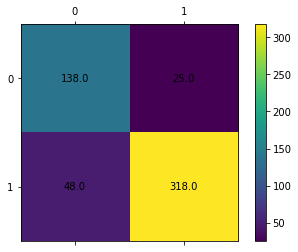

acc: 88.28%


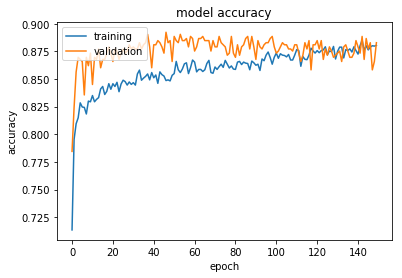

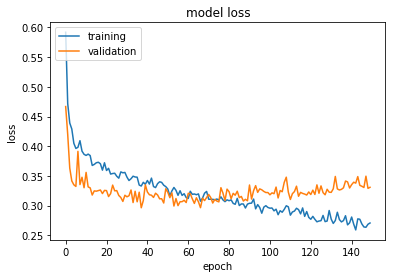

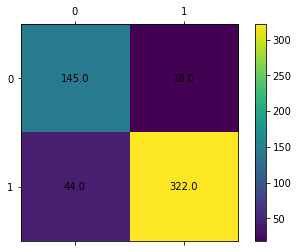

acc: 86.01%


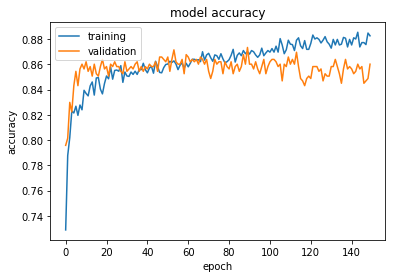

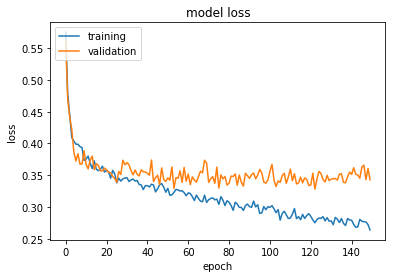

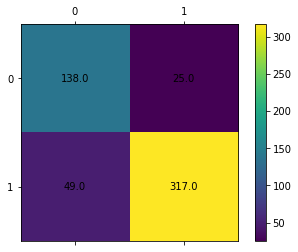

acc: 82.95%


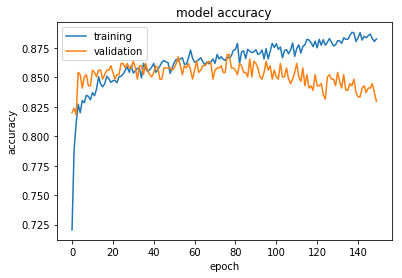

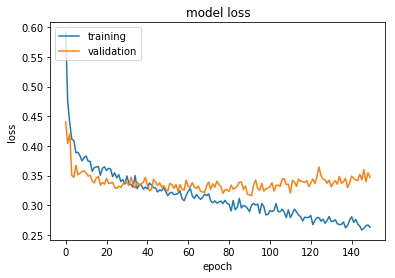

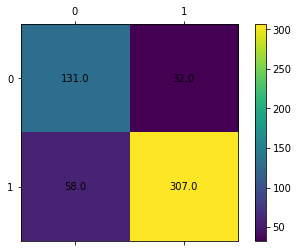

In [29]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
loss = []
for train, test in kfold.split(X, y):
    
    model = init_model(features)
    
    X_train_k =X[train].reshape(X[train].shape[0], X[train].shape[1], 1)
    X_test_k = X[test].reshape(X[test].shape[0], X[test].shape[1], 1)
    history = LossHistory()
    hiss = model.fit(X_train_k, y[train], epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test_k,y[test]), verbose=0)
    scores = model.evaluate(X_test_k, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    loss.append(scores[0])
#     print(score)
    plt.plot(hiss.history['acc'])
    plt.plot(hiss.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss.history['loss'])
    plt.plot(hiss.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_k,y[test],model)


In [30]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss), np.std(loss)))

accuracy::  85.67% (+/- 1.75%)
error:: 0.35 (+/- 0.03)


Shapely Values:
-------

In [31]:
import shap

# select a set of background examples to take an expectation over
background = X_train
X_train.shape

(3149, 33, 1)

In [32]:
model = init_model(features)
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train)

In [33]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_postprocess.shape

(3149, 33)

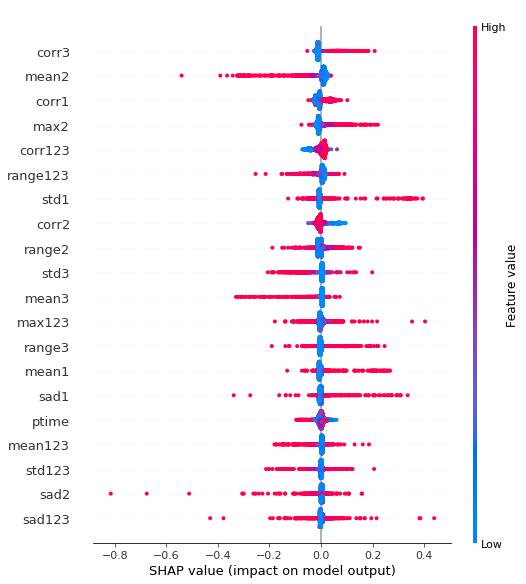

In [34]:
shap.summary_plot(shap_values[0], X_postprocess, feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

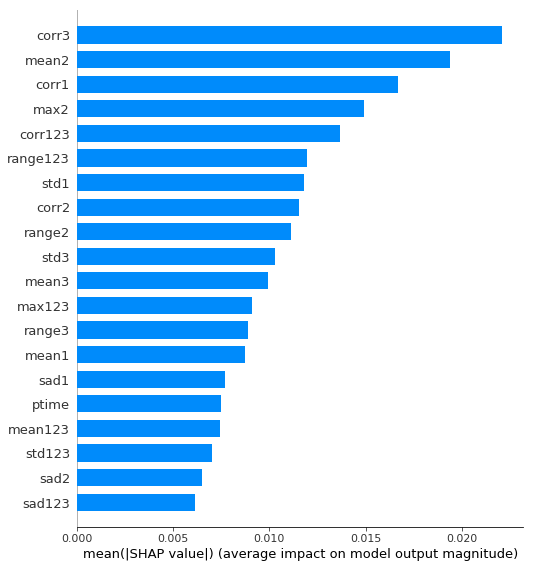

In [35]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar", feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

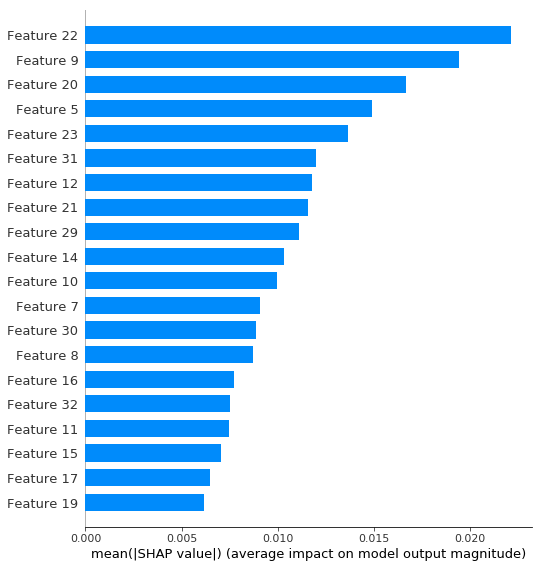

In [36]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")

After Feature Reduction by Shapely Values
-------------

In [37]:
new_summer_features = np.concatenate((X[:,5][:, np.newaxis],X[:,7:13], X[:,14:18],X[:,19:24],X[:,29:33]),axis=1)
new_summer_features.shape

(3705, 20)

In [38]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(new_summer_features, y, test_size=0.15, shuffle=True)

X_train_s = X_train_s.reshape(X_train_s.shape[0], X_train_s.shape[1], 1)
X_test_s = X_test_s.reshape(X_test_s.shape[0], X_test_s.shape[1], 1)

print('X_train dim: ', X_train_s.shape)
print('X_tesy dim: ', X_test_s.shape)
print('y_train dim: ', y_train_s.shape)
print('y_tesy dim: ', y_test_s.shape)

X_train dim:  (3149, 20, 1)
X_tesy dim:  (556, 20, 1)
y_train dim:  (3149, 1)
y_tesy dim:  (556, 1)


In [39]:
features_s = 20
model = init_model(features_s)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 20, 256)           1280      
_________________________________________________________________
batch_normalization_61 (Batc (None, 20, 256)           1024      
_________________________________________________________________
dropout_61 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 20, 128)           131200    
_________________________________________________________________
batch_normalization_62 (Batc (None, 20, 128)           512       
_________________________________________________________________
dropout_62 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 20, 64)            32832     
__________

Train on 3149 samples, validate on 556 samples
Epoch 1/150
 - 9s - loss: 0.6454 - acc: 0.6828 - val_loss: 0.5578 - val_acc: 0.7680
Epoch 2/150
 - 3s - loss: 0.5081 - acc: 0.7583 - val_loss: 0.3960 - val_acc: 0.8183
Epoch 3/150
 - 3s - loss: 0.4653 - acc: 0.7869 - val_loss: 0.3786 - val_acc: 0.8417
Epoch 4/150
 - 3s - loss: 0.4295 - acc: 0.8088 - val_loss: 0.3987 - val_acc: 0.8183
Epoch 5/150
 - 3s - loss: 0.4227 - acc: 0.8098 - val_loss: 0.3827 - val_acc: 0.8309
Epoch 6/150
 - 3s - loss: 0.4118 - acc: 0.8180 - val_loss: 0.3591 - val_acc: 0.8399
Epoch 7/150
 - 3s - loss: 0.3988 - acc: 0.8215 - val_loss: 0.3771 - val_acc: 0.8435
Epoch 8/150
 - 3s - loss: 0.4016 - acc: 0.8206 - val_loss: 0.3688 - val_acc: 0.8363
Epoch 9/150
 - 3s - loss: 0.3893 - acc: 0.8352 - val_loss: 0.3523 - val_acc: 0.8579
Epoch 10/150
 - 3s - loss: 0.3905 - acc: 0.8320 - val_loss: 0.3699 - val_acc: 0.8273
Epoch 11/150
 - 3s - loss: 0.3980 - acc: 0.8253 - val_loss: 0.3663 - val_acc: 0.8327
Epoch 12/150
 - 3s - loss: 

Epoch 97/150
 - 3s - loss: 0.3145 - acc: 0.8609 - val_loss: 0.3560 - val_acc: 0.8525
Epoch 98/150
 - 3s - loss: 0.3124 - acc: 0.8577 - val_loss: 0.3471 - val_acc: 0.8579
Epoch 99/150
 - 3s - loss: 0.3203 - acc: 0.8628 - val_loss: 0.3501 - val_acc: 0.8489
Epoch 100/150
 - 3s - loss: 0.3198 - acc: 0.8615 - val_loss: 0.3528 - val_acc: 0.8489
Epoch 101/150
 - 3s - loss: 0.3089 - acc: 0.8650 - val_loss: 0.3403 - val_acc: 0.8561
Epoch 102/150
 - 3s - loss: 0.3038 - acc: 0.8650 - val_loss: 0.3570 - val_acc: 0.8489
Epoch 103/150
 - 3s - loss: 0.3038 - acc: 0.8688 - val_loss: 0.3502 - val_acc: 0.8543
Epoch 104/150
 - 3s - loss: 0.3096 - acc: 0.8644 - val_loss: 0.3569 - val_acc: 0.8489
Epoch 105/150
 - 3s - loss: 0.3113 - acc: 0.8641 - val_loss: 0.3511 - val_acc: 0.8561
Epoch 106/150
 - 3s - loss: 0.3189 - acc: 0.8612 - val_loss: 0.3425 - val_acc: 0.8561
Epoch 107/150
 - 3s - loss: 0.3059 - acc: 0.8657 - val_loss: 0.3440 - val_acc: 0.8525
Epoch 108/150
 - 3s - loss: 0.3094 - acc: 0.8692 - val_lo

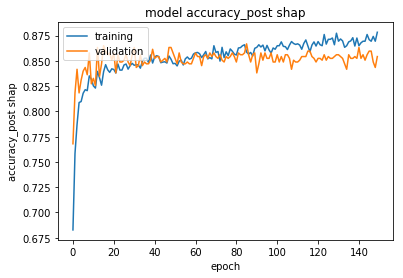

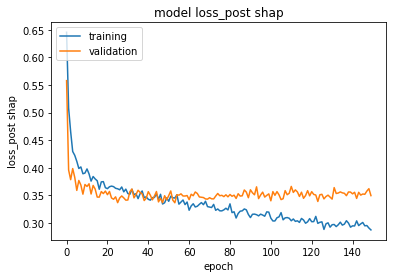

In [40]:
history_s = LossHistory()
hiss_s = model.fit(X_train_s, y_train_s, epochs=150, batch_size=32,
                callbacks=[history_s],
                validation_data=(X_test_s,y_test_s), verbose=2)
score_s = model.evaluate(X_test_s,y_test_s, batch_size=32)
print(score_s)
plt.plot(hiss_s.history['acc'])
plt.plot(hiss_s.history['val_acc'])
plt.title('model accuracy_post shap')
plt.ylabel('accuracy_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_s.history['loss'])
plt.plot(hiss_s.history['val_loss'])
plt.title('model loss_post shap')
plt.ylabel('loss_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

y_pred = model.predict(X_test_s)

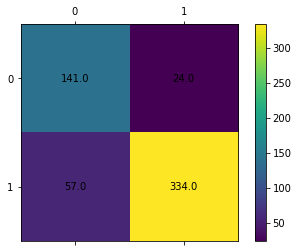

In [41]:
conf_matrix(X_test_s,y_test_s,model)

Early Stopping:
------

In [42]:
model = init_model(features_s)

Training and Testing:


Train on 3149 samples, validate on 556 samples
Epoch 1/150
 - 9s - loss: 0.6219 - acc: 0.6974 - val_loss: 0.5300 - val_acc: 0.7644
Epoch 2/150
 - 3s - loss: 0.5016 - acc: 0.7599 - val_loss: 0.4283 - val_acc: 0.8183
Epoch 3/150
 - 3s - loss: 0.4612 - acc: 0.7942 - val_loss: 0.4112 - val_acc: 0.8112
Epoch 4/150
 - 3s - loss: 0.4430 - acc: 0.7898 - val_loss: 0.3745 - val_acc: 0.8435
Epoch 5/150
 - 3s - loss: 0.4258 - acc: 0.8015 - val_loss: 0.3593 - val_acc: 0.8489
Epoch 6/150
 - 3s - loss: 0.4145 - acc: 0.8171 - val_loss: 0.3693 - val_acc: 0.8543
Epoch 7/150
 - 3s - loss: 0.4083 - acc: 0.8177 - val_loss: 0.3615 - val_acc: 0.8453
Epoch 8/150
 - 3s - loss: 0.4062 - acc: 0.8212 - val_loss: 0.3728 - val_acc: 0.8219
Epoch 9/150
 - 3s - loss: 0.4041 - acc: 0.8279 - val_loss: 0.3685 - val_acc: 0.8417
Epoch 10/150
 - 3s - loss: 0.3912 - acc: 0.8266 - val_loss: 0.3651 - val_acc: 0.8561
Epoch 11/150
 - 3s - loss: 0.3888 - acc: 0.8282 - val_loss: 0.3751 - val_acc: 0.8147
Epoch 12/150
 - 3s - loss: 

Epoch 97/150
 - 3s - loss: 0.3150 - acc: 0.8628 - val_loss: 0.3490 - val_acc: 0.8579
Epoch 98/150
 - 3s - loss: 0.3038 - acc: 0.8692 - val_loss: 0.3564 - val_acc: 0.8471
Epoch 99/150
 - 3s - loss: 0.3080 - acc: 0.8625 - val_loss: 0.3422 - val_acc: 0.8543
Epoch 100/150
 - 3s - loss: 0.3134 - acc: 0.8577 - val_loss: 0.3537 - val_acc: 0.8507
Epoch 101/150
 - 3s - loss: 0.3041 - acc: 0.8695 - val_loss: 0.3523 - val_acc: 0.8417
Epoch 102/150
 - 3s - loss: 0.3077 - acc: 0.8685 - val_loss: 0.3462 - val_acc: 0.8471
Epoch 103/150
 - 3s - loss: 0.3086 - acc: 0.8622 - val_loss: 0.3524 - val_acc: 0.8489
Epoch 104/150
 - 3s - loss: 0.3071 - acc: 0.8654 - val_loss: 0.3460 - val_acc: 0.8543
Epoch 105/150
 - 3s - loss: 0.3166 - acc: 0.8669 - val_loss: 0.3448 - val_acc: 0.8507
Epoch 106/150
 - 3s - loss: 0.3031 - acc: 0.8628 - val_loss: 0.3405 - val_acc: 0.8561
Epoch 107/150
 - 3s - loss: 0.3013 - acc: 0.8676 - val_loss: 0.3443 - val_acc: 0.8543
Epoch 108/150
 - 3s - loss: 0.3110 - acc: 0.8606 - val_lo

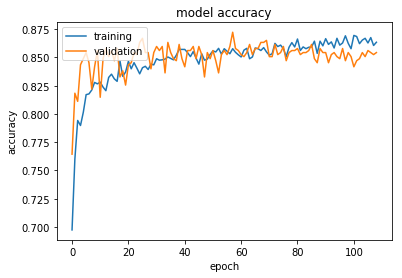

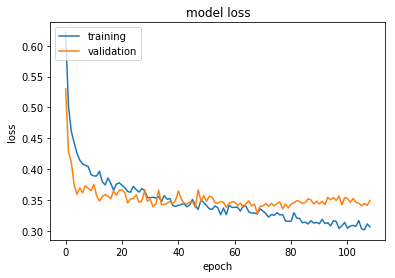

In [43]:
history_se = LossHistory()
es_se = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_se = model.fit(X_train_s, y_train_s, epochs=150, batch_size=32,
                callbacks=[history,es_se],
                validation_data=(X_test_s,y_test_s), verbose=2)
score_se = model.evaluate(X_test_s, y_test_s, batch_size=32)
print('loss and accuracy:: ',score_se)

plt.plot(hiss_se.history['acc'])
plt.plot(hiss_se.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_se.history['loss'])
plt.plot(hiss_se.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

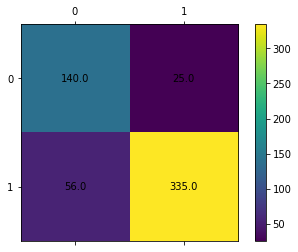

In [44]:
conf_matrix(X_test_s,y_test_s,model)

Model with K-fold Validation:
----------

Epoch 00114: early stopping
acc: 83.77%


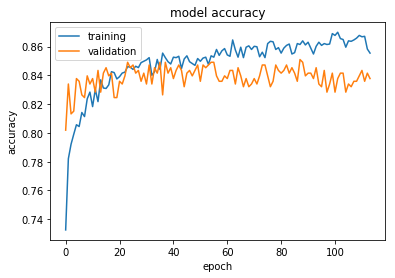

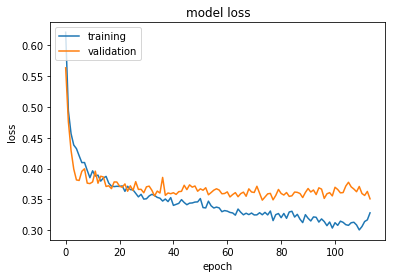

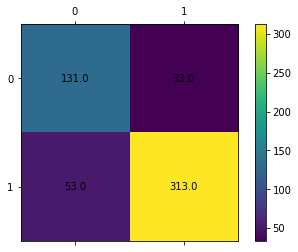

Epoch 00077: early stopping
acc: 83.58%


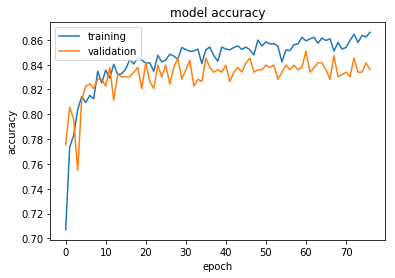

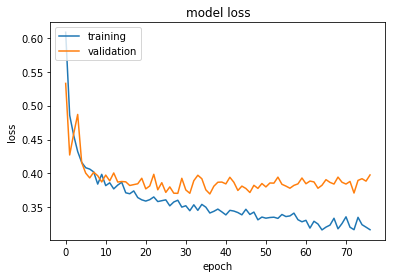

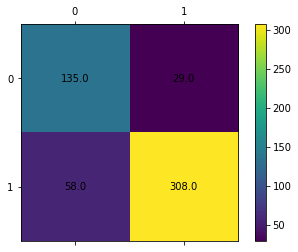

Epoch 00118: early stopping
acc: 85.85%


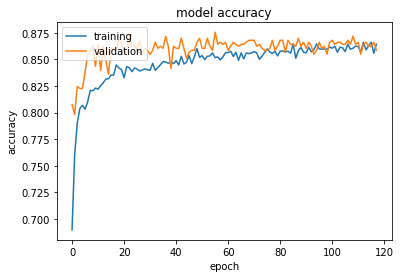

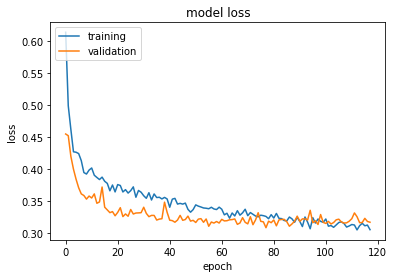

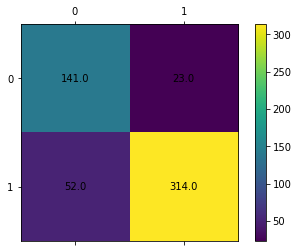

Epoch 00074: early stopping
acc: 86.01%


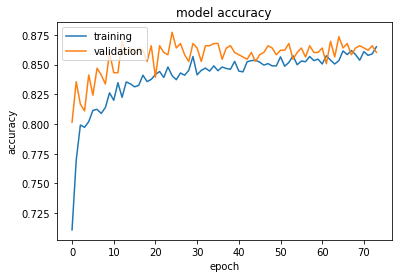

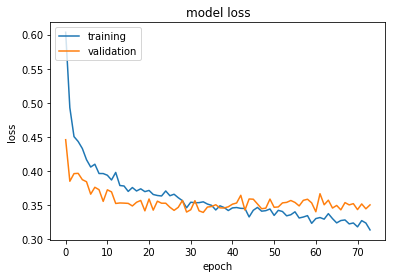

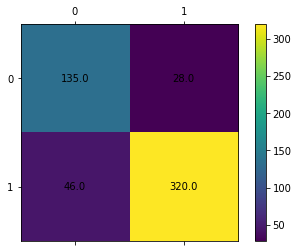

Epoch 00105: early stopping
acc: 87.33%


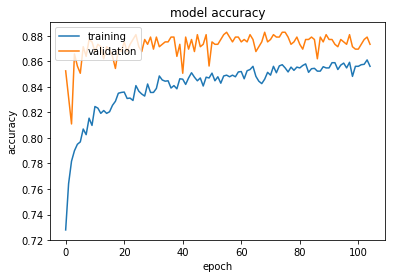

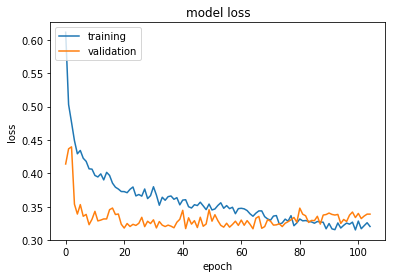

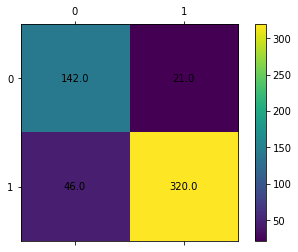

Epoch 00113: early stopping
acc: 86.01%


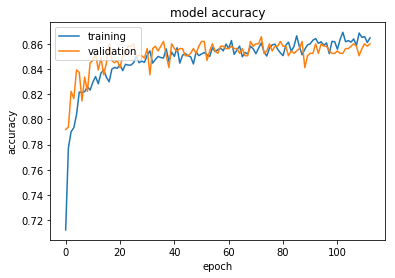

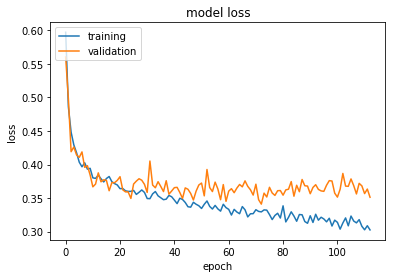

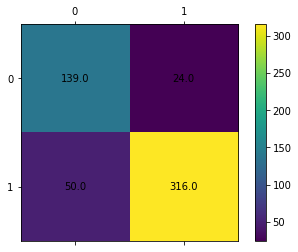

Epoch 00108: early stopping
acc: 85.42%


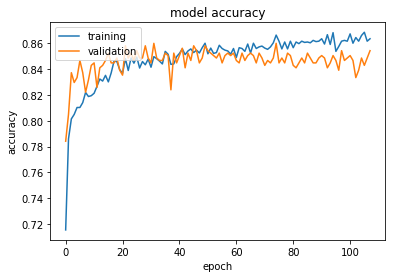

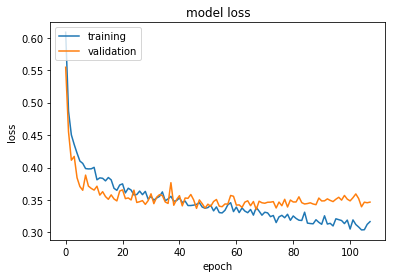

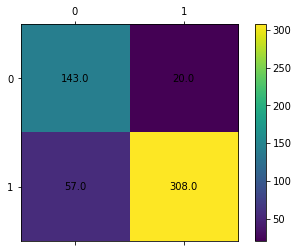

In [45]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_s = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_s = []
loss_s = []
XX = new_summer_features
for train, test in kfold_s.split(XX, y):
    
    model = init_model(features_s)
    
    X_train_ks =XX[train].reshape(XX[train].shape[0], XX[train].shape[1], 1)
    X_test_ks = XX[test].reshape(XX[test].shape[0], XX[test].shape[1], 1)
    history_ks = LossHistory()
    es_ks = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_ks = model.fit(X_train_ks, y[train], epochs=150, batch_size=32,
                callbacks=[history_ks,es_ks],
                validation_data=(X_test_ks,y[test]), verbose=0)
    scores_ks = model.evaluate(X_test_ks, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_ks[1]*100))
    cvscores_s.append(scores_ks[1] * 100)
    loss_s.append(scores_ks[0])
#     print(score)
    plt.plot(hiss_ks.history['acc'])
    plt.plot(hiss_ks.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_ks.history['loss'])
    plt.plot(hiss_ks.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_ks,y[test],model)


In [46]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_s), np.std(cvscores_s)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_s), np.std(loss_s)))

accuracy::  85.43% (+/- 1.23%)
error:: 0.35 (+/- 0.02)


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 83.21%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 79.25%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 81.13%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 83.18%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 84.69%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.34%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 82.39%
82.03% (+/- 1.74%)


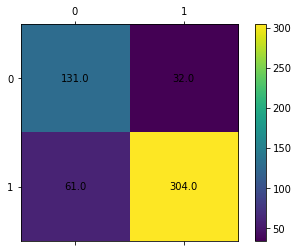

In [59]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score 
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(XX, y):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = XX[train]
    X_test = XX[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, y[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(y[test], y_pred)
    acc = accuracy_score(y[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

PCA:
-------

In [47]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

In [48]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [49]:
pca.n_components_

19

In [50]:
summer_pca = pca.transform(X)

In [51]:
summer_pca.shape

(3705, 19)

In [52]:
from sklearn.model_selection import train_test_split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(summer_pca, y, test_size=0.15, shuffle=True)

In [53]:
X_train_p.shape

(3149, 19)

Early Stopping:
------

In [54]:
features_p = X_train_p.shape[1]
model = init_model(features_p)

X_train_p = X_train_p.reshape(X_train_p.shape[0], X_train_p.shape[1], 1)
X_test_p = X_test_p.reshape(X_test_p.shape[0], X_test_p.shape[1], 1)

print('X_train dim: ', X_train_p.shape)
print('X_tesy dim: ', X_test_p.shape)
print('y_train dim: ', y_train_p.shape)
print('y_tesy dim: ', y_test_p.shape)

X_train dim:  (3149, 19, 1)
X_tesy dim:  (556, 19, 1)
y_train dim:  (3149, 1)
y_tesy dim:  (556, 1)


Training and Testing:


Train on 3149 samples, validate on 556 samples
Epoch 1/150
 - 12s - loss: 0.6432 - acc: 0.7050 - val_loss: 0.5022 - val_acc: 0.7788
Epoch 2/150
 - 3s - loss: 0.5083 - acc: 0.7774 - val_loss: 0.4007 - val_acc: 0.8399
Epoch 3/150
 - 3s - loss: 0.4727 - acc: 0.7901 - val_loss: 0.4231 - val_acc: 0.8112
Epoch 4/150
 - 3s - loss: 0.4630 - acc: 0.7933 - val_loss: 0.3539 - val_acc: 0.8633
Epoch 5/150
 - 3s - loss: 0.4239 - acc: 0.8069 - val_loss: 0.3583 - val_acc: 0.8561
Epoch 6/150
 - 3s - loss: 0.4073 - acc: 0.8212 - val_loss: 0.3568 - val_acc: 0.8615
Epoch 7/150
 - 3s - loss: 0.4092 - acc: 0.8164 - val_loss: 0.3477 - val_acc: 0.8615
Epoch 8/150
 - 3s - loss: 0.4081 - acc: 0.8142 - val_loss: 0.3551 - val_acc: 0.8543
Epoch 9/150
 - 3s - loss: 0.3947 - acc: 0.8215 - val_loss: 0.3641 - val_acc: 0.8507
Epoch 10/150
 - 3s - loss: 0.3825 - acc: 0.8241 - val_loss: 0.3461 - val_acc: 0.8651
Epoch 11/150
 - 4s - loss: 0.3886 - acc: 0.8266 - val_loss: 0.3545 - val_acc: 0.8489
Epoch 12/150
 - 3s - loss:

Epoch 97/150
 - 3s - loss: 0.3148 - acc: 0.8663 - val_loss: 0.3364 - val_acc: 0.8669
Epoch 98/150
 - 3s - loss: 0.3106 - acc: 0.8628 - val_loss: 0.3350 - val_acc: 0.8633
Epoch 99/150
 - 3s - loss: 0.3093 - acc: 0.8666 - val_loss: 0.3386 - val_acc: 0.8669
Epoch 100/150
 - 3s - loss: 0.3130 - acc: 0.8666 - val_loss: 0.3254 - val_acc: 0.8687
Epoch 101/150
 - 3s - loss: 0.3125 - acc: 0.8641 - val_loss: 0.3292 - val_acc: 0.8633
Epoch 102/150
 - 3s - loss: 0.3083 - acc: 0.8650 - val_loss: 0.3242 - val_acc: 0.8687
Epoch 103/150
 - 3s - loss: 0.3037 - acc: 0.8650 - val_loss: 0.3339 - val_acc: 0.8615
Epoch 104/150
 - 3s - loss: 0.3064 - acc: 0.8650 - val_loss: 0.3287 - val_acc: 0.8759
Epoch 105/150
 - 3s - loss: 0.3094 - acc: 0.8663 - val_loss: 0.3363 - val_acc: 0.8723
Epoch 106/150
 - 3s - loss: 0.3023 - acc: 0.8682 - val_loss: 0.3270 - val_acc: 0.8705
Epoch 107/150
 - 3s - loss: 0.3046 - acc: 0.8666 - val_loss: 0.3314 - val_acc: 0.8615
Epoch 108/150
 - 3s - loss: 0.2989 - acc: 0.8682 - val_lo

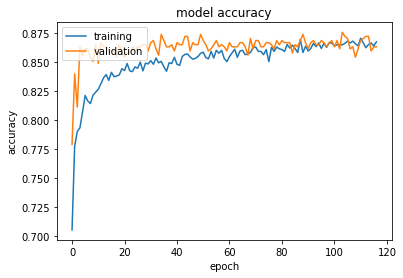

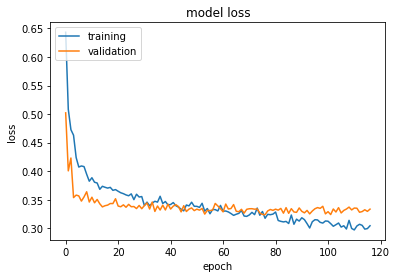

In [55]:
history_pe = LossHistory()
es_pe = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_pe = model.fit(X_train_p, y_train_p, epochs=150, batch_size=32,
                callbacks=[history_pe,es_pe],
                validation_data=(X_test_p,y_test_p), verbose=2)
score_pe = model.evaluate(X_test_p, y_test_p, batch_size=32)
print('loss and accuracy:: ',score_pe)

plt.plot(hiss_pe.history['acc'])
plt.plot(hiss_pe.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_pe.history['loss'])
plt.plot(hiss_pe.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

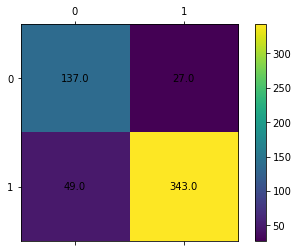

In [56]:
conf_matrix(X_test_p,y_test_p,model)

Model with K-fold Validation:
----------

Epoch 00087: early stopping
acc: 84.91%


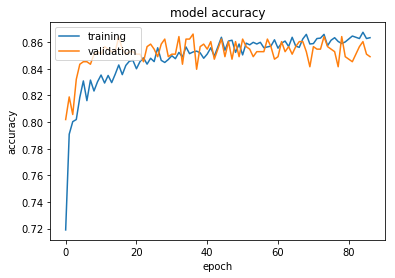

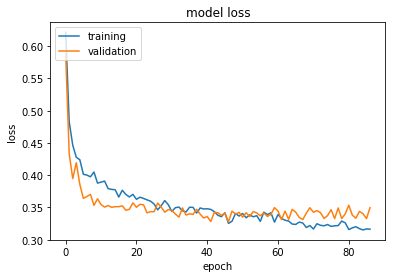

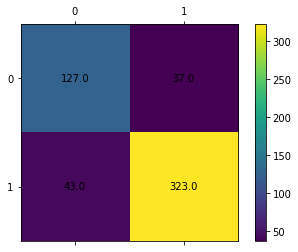

Epoch 00135: early stopping
acc: 83.02%


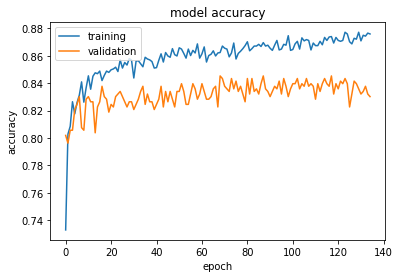

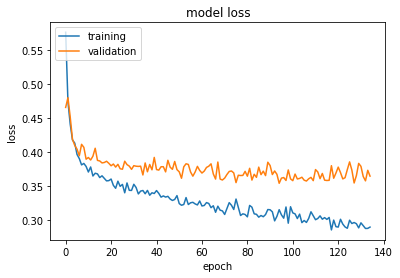

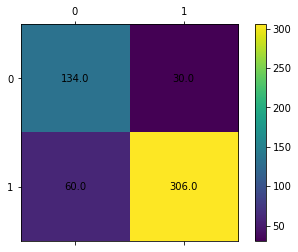

acc: 87.17%


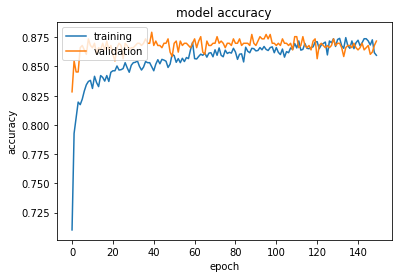

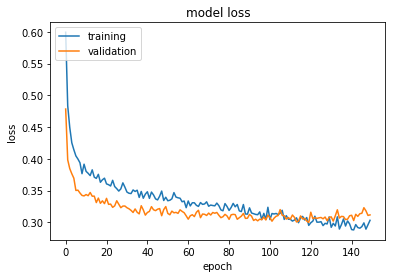

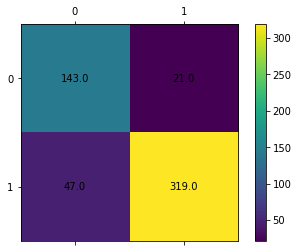

Epoch 00069: early stopping
acc: 86.58%


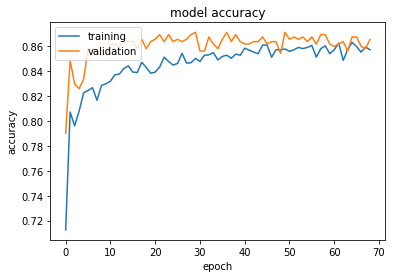

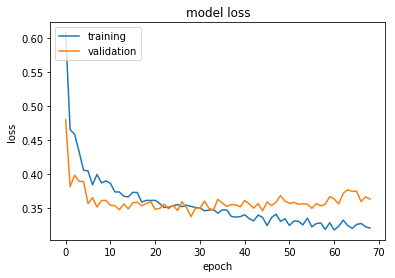

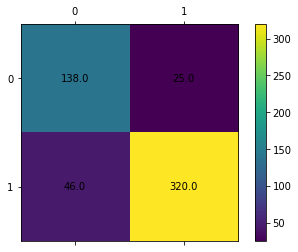

Epoch 00079: early stopping
acc: 88.66%


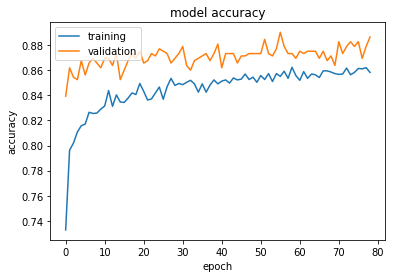

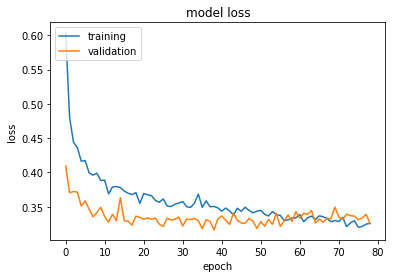

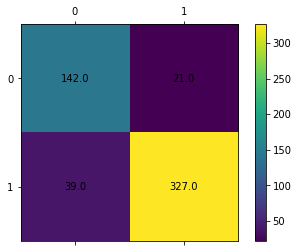

Epoch 00063: early stopping
acc: 85.82%


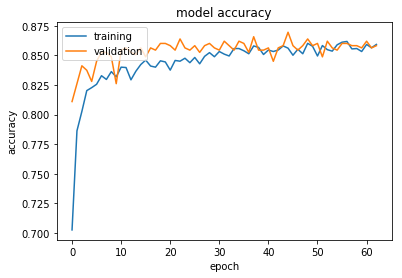

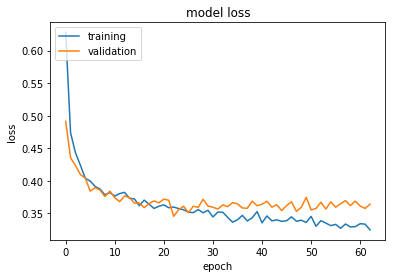

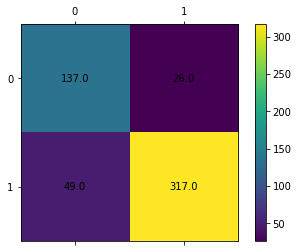

Epoch 00073: early stopping
acc: 83.90%


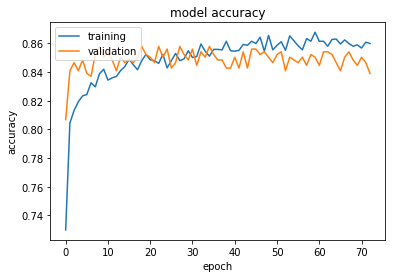

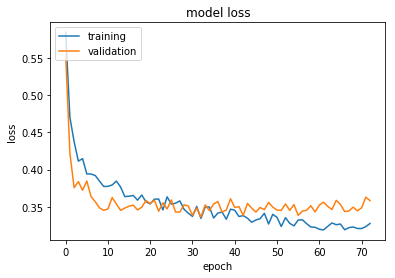

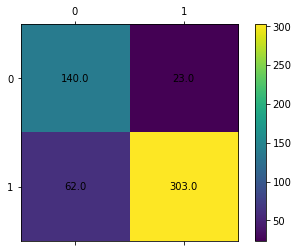

In [57]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_p = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_p = []
loss_p = []
XXX = summer_pca
for train, test in kfold_s.split(XXX, y):
    
    model = init_model(features_p)
    
    X_train_kp =XXX[train].reshape(XXX[train].shape[0], XXX[train].shape[1], 1)
    X_test_kp = XXX[test].reshape(XXX[test].shape[0], XXX[test].shape[1], 1)
    history_kp = LossHistory()
    es_kp = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_kp = model.fit(X_train_kp, y[train], epochs=150, batch_size=32,
                callbacks=[history_kp,es_kp],
                validation_data=(X_test_kp,y[test]), verbose=0)
    scores_kp = model.evaluate(X_test_kp, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_kp[1]*100))
    cvscores_p.append(scores_kp[1] * 100)
    loss_p.append(scores_kp[0])
#     print(score)
    plt.plot(hiss_kp.history['acc'])
    plt.plot(hiss_kp.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_kp.history['loss'])
    plt.plot(hiss_kp.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_kp,y[test],model)


In [58]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_p), np.std(cvscores_p)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_p), np.std(loss_p)))

accuracy::  85.72% (+/- 1.80%)
error:: 0.35 (+/- 0.02)


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 85.09%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 82.08%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 85.66%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 85.26%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 86.77%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 83.93%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 83.90%
84.67% (+/- 1.40%)


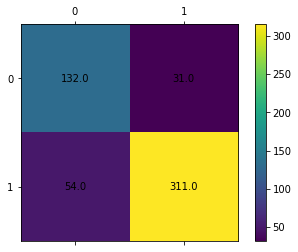

In [60]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score 
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(XXX, y):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = XXX[train]
    X_test = XXX[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, y[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(y[test], y_pred)
    acc = accuracy_score(y[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()